# 네이버 금융
https://finance.naver.com/sise/sise_market_sum.nhn?&page=1

# 
## BeautifulSoup

In [1]:
import pandas as pd
import numpy as np

In [2]:
import csv
import urllib.request
from bs4 import BeautifulSoup

In [3]:
def scrape_stock():
    
    url = "https://finance.naver.com/sise/sise_market_sum.nhn?&page=1"    
    stock_url = urllib.request.urlopen(url).read() 
    soup = BeautifulSoup(stock_url, 'html.parser', from_encoding='euc-kr')
    
    colnames = soup.find('table', {'class': 'type_2'}).find('thead').find_all('th')
    columns = [names.get_text() for names in colnames]
    stock_df = pd.DataFrame(columns=columns)
    stock_df

    idx = 0
    
    for page in range(1, 6):

        url = "https://finance.naver.com/sise/sise_market_sum.nhn?&page=" + str(page)    
        stock_url = urllib.request.urlopen(url).read() 
        soup = BeautifulSoup(stock_url, 'html.parser', from_encoding='euc-kr')

        data_rows = soup.find('table', {'class': 'type_2'}).find('tbody').find_all('tr')
        for row in data_rows:
            columns = row.find_all('td')

            if len(columns) <= 1:
                continue
            data = [column.get_text().strip() for column in columns]
            stock_df.loc[idx] = data

            idx += 1
    
    stock_df.drop('N', axis=1).to_csv('stock_df.csv', index=False)

In [4]:
scrape_stock()

In [6]:
stock_df = pd.read_csv('stock_df.csv')

In [7]:
stock_df.shape

(250, 12)

In [8]:
stock_df.head(1)

,종목명,현재가,전일비,등락률,액면가,시가총액,상장주식수,외국인비율,거래량,PER,ROE,토론실
0,삼성전자,"56,200",200,+0.36%,100,"3,355,018","5,969,783",49.5,"12,738,632",8.52,13.92,NaN


# 
# 
# 
# 
## Selenium

In [96]:
import pandas as pd
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By

In [97]:
browser = webdriver.Chrome('./chromedriver.exe')

C:\Users\이찬솔\AppData\Local\Temp\ipykernel_12136\1978562881.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Chrome('./chromedriver.exe')


# 
#### 1. 페이지 이동

In [98]:
url = "https://finance.naver.com/sise/sise_market_sum.nhn?&page="
browser.get(url)

# 
#### 2. 조회 항목 (체크되어 있는 항목) 초기화
- **각 항목들은 체크가 되어있을 시 class='choice'로 표시되어 있음**
- **각 항목의 체크박스 \<td>태그 들은 name='fieldIds'를 보유**

In [99]:
checkboxes = browser.find_elements(By.NAME, 'fieldIds')

- **총 27개의 조회 가능 항목**

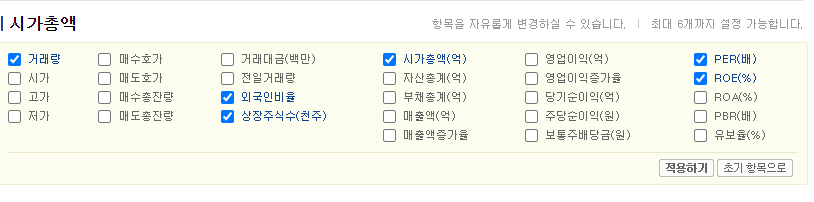

In [100]:
len(checkboxes)

27

In [101]:
for checkbox in checkboxes:
    if checkbox.is_selected(): # 만약 체크박스가 체크되어 있을 시
        checkbox.click() # 클릭 (체크 헤제)

# 
#### 3. 원하는 항목 체크

In [102]:
from bs4 import BeautifulSoup

In [103]:
url = "https://finance.naver.com/sise/sise_market_sum.nhn?&page="
stock_url = urllib.request.urlopen(url).read() 
soup = BeautifulSoup(stock_url, 'html.parser', from_encoding='euc-kr')

In [104]:
item_list = soup.find('div', {'class': 'subcnt_sise_item_top sub810t'}).\
    find('table', {'class': 'item_list'}).find_all('td')

items = []
for item in item_list:
    if item.find('label') == None:
        continue
    items.append(item.find('label').get_text())

In [105]:
items

['거래량',
 '매수호가',
 '거래대금',
 '시가총액',
 '영업이익',
 'PER',
 '시가',
 '매도호가',
 '전일거래량',
 '자산총계',
 '영업이익증가율',
 'ROE',
 '고가',
 '매수총잔량',
 '외국인비율',
 '부채총계',
 '당기순이익',
 'ROA',
 '저가',
 '매도총잔량',
 '상장주식수',
 '매출액',
 '주당순이익',
 'PBR',
 '매출액증가율',
 '보통주배당금',
 '유보율']

# 

- **원하는 항목 선택**

In [106]:
items_to_select = items[:3]
items_to_select

['거래량', '매수호가', '거래대금']

- **checkbox의 부모 element 안에서, \<label> element를 탐색하여 클릭**

In [107]:
for checkbox in checkboxes:
    parent = checkbox.find_element(By.XPATH, '..') # 부모 element
    label = parent.find_element(By.TAG_NAME, 'label') 
    if label.text in items_to_select:
        checkbox.click()

# 
#### 4. 적용하기 버튼 클릭

In [108]:
btn_apply = browser.find_element(By.XPATH, '//a[@href="javascript:fieldSubmit()"]')
btn_apply.click()

- **초기화 버튼**

In [109]:
# btn_reset = browser.find_element(By.XPATH, '//a[@href="javascript:fieldDefault()"]')
# btn_reset.click()

# 
#### 5. 데이터 추출

In [110]:
import lxml

In [111]:
df = pd.read_html(browser.page_source)

In [112]:
df[0]

,0,1,2,3,4,5
0,거래량,매수호가,거래대금(백만),시가총액(억),영업이익(억),PER(배)
1,시가,매도호가,전일거래량,자산총계(억),영업이익증가율,ROE(%)
2,고가,매수총잔량,외국인비율,부채총계(억),당기순이익(억),ROA(%)
3,저가,매도총잔량,상장주식수(천주),매출액(억),주당순이익(원),PBR(배)
4,NaN,NaN,NaN,매출액증가율,보통주배당금(원),유보율(%)


In [113]:
df[1].head(3)

,N,종목명,현재가,전일비,등락률,액면가,거래량,거래대금,매수호가,토론실,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,삼성전자,56200.0,200.0,+0.36%,100.0,12738632.0,712230.0,56200.0,NaN,NaN,NaN,NaN
2,2.0,LG에너지솔루션,506000.0,5000.0,-0.98%,500.0,914537.0,463762.0,505000.0,NaN,NaN,NaN,NaN


In [115]:
df = pd.read_html(browser.page_source)[1]
df.shape

(81, 13)

- **결측값 제거**

In [118]:
df1 = df.dropna(axis='index', how='all')
df1.shape
# 행 전체가 결측치일 경우 해당 열 제거

(50, 13)

In [119]:
df2 = df1.dropna(axis='columns', how='all')
df2.shape

(50, 9)

# 
#### 6. 파일 저장

In [38]:
import os
import time

In [39]:
f_name = 'stock.csv'

In [41]:
f_name = 'stock.csv'
if os.path.exists(f_name): # 파일이 있다면 => 헤더 미포함한 데이터를 추가
    df2.to_csv(f_name, encoding='utf-8-sig', index=False, mode='a', header=False)
else: # 파일이 없다면 => 헤더 포함
    df2.to_csv(f_name, encoding='utf-8-sig', index=False)

# 
# 
# 
# 

In [42]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [201]:
def scrape_stock_info(page_num=100):
    
    print("생성할 csv 파일 이름을 입력하세요")
    print("(현재 존재하는 csv 파일 이름과 중복되지 않아야 합니다.)")
    print("\n현재 폴더 내 csv 파일 목록 : ")
    print("----------------------------")
    for i in range(len(os.listdir())):
        if ".csv" in os.listdir()[i]:
            print(os.listdir()[i])
            
    print("\n----------------------------")
    
    time.sleep(1)
    file_name = input('\n생성할 csv 파일 이름 (.csv 제외하고 입력) : ')
    print('\n')

    url = "https://finance.naver.com/sise/sise_market_sum.nhn?&page="
    stock_url = urllib.request.urlopen(url).read() 
    soup = BeautifulSoup(stock_url, 'html.parser', from_encoding='euc-kr')

    print("\n\n아래 항목 중 조회하고자 하는 항목 (최대 6개)들을 입력하시오")
    print("{입력 예시 : 거래량, 매수호가, 시가총액}")
    print("\n----------------------------")

    item_list = soup.find('div', {'class': 'subcnt_sise_item_top sub810t'}).\
    find('table', {'class': 'item_list'}).find_all('td')

    time.sleep(1)
    items = []
    for item in item_list:
        if item.find('label') == None:
            continue
        
        print(item.find('label').get_text())
    print("\n----------------------------")

    time.sleep(2)
    items_to_select = list(input('조회 항목 : ').replace(" ", "").split(','))
    
    time.sleep(1)
    print("\n")
    print(str(items_to_select)+ " 항목들에 대한 데이터를 수집합니다.")
    
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    browser = webdriver.Chrome('./chromedriver.exe', options=chrome_options)
    url = "https://finance.naver.com/sise/sise_market_sum.nhn?&page="
    browser.get(url)

    checkboxes = browser.find_elements(By.NAME, 'fieldIds')
    for checkbox in checkboxes:
        if checkbox.is_selected(): # 만약 체크박스가 체크되어 있을 시
            checkbox.click() # 클릭 (체크 헤제)

    for checkbox in checkboxes:
        parent = checkbox.find_element(By.XPATH, '..') # 부모 element
        label = parent.find_element(By.TAG_NAME, 'label') 
        if label.text in items_to_select:
            checkbox.click()

    btn_apply = browser.find_element(By.XPATH, '//a[@href="javascript:fieldSubmit()"]')
    btn_apply.click()

    for page in range(1, page_num):
        if page == 1:
            df = pd.read_html(browser.page_source)[1]
            df1 = df.dropna(axis='index', how='all')
            df2 = df1.dropna(axis='columns', how='all')
            
            f_name = str(file_name) + '.csv'
            if os.path.exists(f_name): 
                df2.to_csv(f_name, encoding='utf-8-sig', index=False, mode='a', header=False)
            else: 
                df2.to_csv(f_name, encoding='utf-8-sig', index=False)
        else:
            url = "https://finance.naver.com/sise/sise_market_sum.nhn?&page=" + str(page)
            browser.get(url)
            
            df = pd.read_html(browser.page_source)[1]
            df1 = df.dropna(axis='index', how='all')
            df2 = df1.dropna(axis='columns', how='all')

            if df2.shape == (0, 0):
                break
            else:
                df2.to_csv(f_name, encoding='utf-8-sig', index=False, mode='a', header=False)
    
    print("수집 완료! \n"+ str(file_name) + ".csv 파일이 생성되었습니다!")
    data = pd.read_csv(str(file_name + ".csv"))

In [202]:
scrape_stock_info()

생성할 csv 파일 이름을 입력하세요
(현재 존재하는 csv 파일 이름과 중복되지 않아야 합니다.)

현재 폴더 내 csv 파일 목록 : 
----------------------------
stock.csv
stock_df.csv

----------------------------

생성할 csv 파일 이름 (.csv 제외하고 입력) : 이찬솔




아래 항목 중 조회하고자 하는 항목 (최대 6개)들을 입력하시오
{입력 예시 : 거래량, 매수호가, 시가총액}

----------------------------
거래량
매수호가
거래대금
시가총액
영업이익
PER
시가
매도호가
전일거래량
자산총계
영업이익증가율
ROE
고가
매수총잔량
외국인비율
부채총계
당기순이익
ROA
저가
매도총잔량
상장주식수
매출액
주당순이익
PBR
매출액증가율
보통주배당금
유보율

----------------------------
조회 항목 : 거래량, PER


['거래량', 'PER'] 항목들에 대한 데이터를 수집합니다.


C:\Users\이찬솔\AppData\Local\Temp\ipykernel_12136\2369596010.py:48: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Chrome('./chromedriver.exe', options=chrome_options)


수집 완료! 
이찬솔.csv 파일이 생성되었습니다!


In [208]:
df = pd.read_csv("이찬솔.csv")
df.shape, df.dtypes

((1861, 8),
 N      float64
 종목명     object
 현재가    float64
 전일비    float64
 등락률     object
 액면가    float64
 거래량    float64
 PER    float64
 dtype: object)

In [209]:
df.N = df.N.apply(int)
df.head()

,N,종목명,현재가,전일비,등락률,액면가,거래량,PER
0,1,삼성전자,56200.0,200.0,+0.36%,100.0,12738632.0,8.52
1,2,LG에너지솔루션,506000.0,5000.0,-0.98%,500.0,914537.0,840.53
2,3,SK하이닉스,91200.0,800.0,-0.87%,5000.0,2210421.0,5.78
3,4,삼성바이오로직스,802000.0,5000.0,-0.62%,2500.0,38088.0,106.66
4,5,LG화학,635000.0,23000.0,-3.50%,5000.0,266934.0,22.39


In [210]:
df.tail()

,N,종목명,현재가,전일비,등락률,액면가,거래량,PER
1856,1857,ARIRANG 코스닥150,10775.0,155.0,-1.42%,0.0,580.0,NaN
1857,1858,KBSTAR 200커뮤니케이션서비스,12145.0,65.0,-0.53%,0.0,9.0,NaN
1858,1859,KBSTAR 200에너지화학,10780.0,340.0,-3.06%,0.0,218.0,NaN
1859,1860,KBSTAR 200산업재,11240.0,260.0,-2.26%,0.0,4005.0,NaN
1860,1861,KBSTAR 200경기소비재,9780.0,15.0,-0.15%,0.0,231.0,NaN
